In [7]:
import pandas as pd

# Load and preprocess the data
train_data = pd.read_csv('aug_train.csv', header=None)
validate_data = pd.read_csv('validate.csv', header=None)
test_data = pd.read_csv('test.csv', header=None)

train_samples = train_data.iloc[:, 1:].values.T
train_labels = train_data.iloc[:, 0].values.reshape(1, -1)

validation_samples = validate_data.iloc[:, 1:].values.T
validation_labels = validate_data.iloc[:, 0].values.reshape(1, -1)

test_samples = test_data.iloc[:, 1:].values.T 


In [15]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.dropout_rate = dropout_rate

        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        self.W3 = None
        self.b3 = None

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return Z > 0

    def softmax(self, Z):
        exp_Z = np.exp(Z)
        return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

    def one_hot(self, Y):
        Y = Y.astype(int)  # Convert labels to integers
        one_hot_Y = np.zeros((Y.size, self.output_size + 1))
        one_hot_Y[np.arange(Y.size), Y.flatten()] = 1
        return one_hot_Y.T

    def forward(self, X, training=True):
        Z1 = self.W1.dot(X) + self.b1
        A1 = self.relu(Z1)
        if training:
            mask1 = np.random.rand(*A1.shape) > self.dropout_rate
            A1 *= mask1 / (1 - self.dropout_rate)

        Z2 = self.W2.dot(A1) + self.b2
        A2 = self.relu(Z2)
        if training:
            mask2 = np.random.rand(*A2.shape) > self.dropout_rate
            A2 *= mask2 / (1 - self.dropout_rate)

        Z3 = self.W3.dot(A2) + self.b3
        A3 = self.softmax(Z3)

        return Z1, A1, Z2, A2, Z3, A3

    def backward(self, Z1, A1, Z2, A2, Z3, A3, X, Y):
        m = Y.shape[1]
        one_hot_Y = self.one_hot(Y)

        dZ3 = A3 - one_hot_Y
        dW3 = (1 / m) * dZ3.dot(A2.T)
        db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

        dZ2 = self.W3.T.dot(dZ3) * self.relu_derivative(Z2)
        dW2 = (1 / m) * dZ2.dot(A1.T)
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

        dZ1 = self.W2.T.dot(dZ2) * self.relu_derivative(Z1)
        dW1 = (1 / m) * dZ1.dot(X.T)
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

        return dW1, db1, dW2, db2, dW3, db3

    def update_weights(self, dW1, db1, dW2, db2, dW3, db3, learning_rate):
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3

    def get_prediction(self, A3):
        return np.argmax(A3, axis=0)

    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y) / Y.size

    def gradient_descent(self, X, Y, X_val, Y_val, epochs, learning_rate, batch_size):
        n_x, m = X.shape
        n_y = int(Y.max() + 1)

        self.W1 = np.random.randn(self.hidden_size1, n_x) * np.sqrt(2 / n_x)  # Xavier initialization
        self.b1 = np.zeros((self.hidden_size1, 1))
        self.W2 = np.random.randn(self.hidden_size2, self.hidden_size1) * np.sqrt(2 / self.hidden_size1)  # Xavier initialization
        self.b2 = np.zeros((self.hidden_size2, 1))
        self.W3 = np.random.randn(n_y, self.hidden_size2) * np.sqrt(2 / n_y)  # Xavier initialization
        self.b3 = np.zeros((n_y, 1))

        num_batches = m // batch_size

        train_accuracy_list = []
        validation_accuracy_list = []

        for epoch in range(epochs):
            for batch in range(num_batches):
                start = batch * batch_size
                end = start + batch_size

                X_batch = X[:, start:end]
                Y_batch = Y[:, start:end]

                Z1, A1, Z2, A2, Z3, A3 = self.forward(X_batch, training=True)
                dW1, db1, dW2, db2, dW3, db3 = self.backward(Z1, A1, Z2, A2, Z3, A3, X_batch, Y_batch)
                self.update_weights(dW1, db1, dW2, db2, dW3, db3, learning_rate)

            if epoch % 10 == 0:
                Z1_train, A1_train, Z2_train, A2_train, Z3_train, A3_train = self.forward(X, training=False)
                train_predictions = self.get_prediction(A3_train)
                train_accuracy = self.get_accuracy(train_predictions, Y)
                train_accuracy_list.append(train_accuracy)
                print(f"Epoch {epoch}: Train Accuracy = {train_accuracy}")

                Z1_val, A1_val, Z2_val, A2_val, Z3_val, A3_val = self.forward(X_val, training=False)
                val_predictions = self.get_prediction(A3_val)
                val_accuracy = self.get_accuracy(val_predictions, Y_val)
                validation_accuracy_list.append(val_accuracy)
                print(f"Epoch {epoch}: Validation Accuracy = {val_accuracy}")
        return train_accuracy_list, validation_accuracy_list
    
    def test(self, X_test):
        Z1_test, A1_test, Z2_test, A2_test, Z3_test, A3_test = self.forward(X_test, training=False)
        test_predictions = self.get_prediction(A3_test)
        return test_predictions

# Params
input_size = 3072
hidden_size1 = 512
hidden_size2 = 256
output_size = 10
epochs = 140
batch_size = 64
learning_rate = 0.01
dropout_rate = 0.21



In [16]:
# Create an instance of the NeuralNetwork class
nn = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)

# Train the neural network
train_accuracy_list, validation_accuracy_list = nn.gradient_descent(train_samples, train_labels, validation_samples, validation_labels, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)


Epoch 0: Train Accuracy = 0.231
Epoch 0: Validation Accuracy = 0.269
Epoch 10: Train Accuracy = 0.37825
Epoch 10: Validation Accuracy = 0.387
Epoch 20: Train Accuracy = 0.43116666666666664
Epoch 20: Validation Accuracy = 0.388
Epoch 30: Train Accuracy = 0.45245833333333335
Epoch 30: Validation Accuracy = 0.399
Epoch 40: Train Accuracy = 0.46525
Epoch 40: Validation Accuracy = 0.415
Epoch 50: Train Accuracy = 0.48025
Epoch 50: Validation Accuracy = 0.415
Epoch 60: Train Accuracy = 0.5052916666666667
Epoch 60: Validation Accuracy = 0.43
Epoch 70: Train Accuracy = 0.5158333333333334
Epoch 70: Validation Accuracy = 0.431
Epoch 80: Train Accuracy = 0.5189583333333333
Epoch 80: Validation Accuracy = 0.42
Epoch 90: Train Accuracy = 0.529875
Epoch 90: Validation Accuracy = 0.433
Epoch 100: Train Accuracy = 0.538625
Epoch 100: Validation Accuracy = 0.432
Epoch 110: Train Accuracy = 0.547125
Epoch 110: Validation Accuracy = 0.442
Epoch 120: Train Accuracy = 0.5514166666666667
Epoch 120: Validati

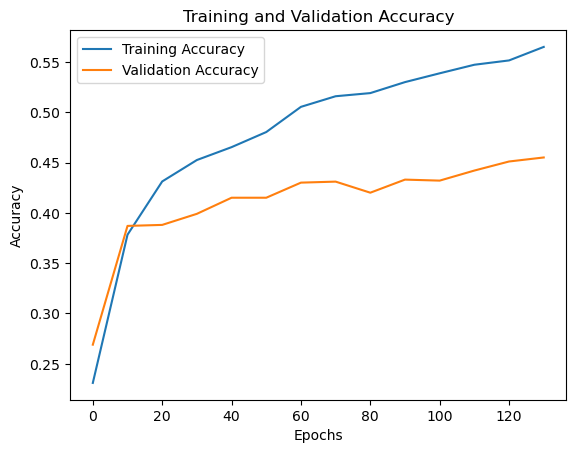

In [17]:
import matplotlib.pyplot as plt

# Create x-axis values
x_epochs = list(range(0, epochs, 10))
# Plotting the training accuracy and validation accuracy
plt.plot(x_epochs, train_accuracy_list, label='Training Accuracy')
plt.plot(x_epochs, validation_accuracy_list, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [ ]:

# Test the neural network
test_predictions = nn.test(test_samples)

# Save the test predictions to the test.csv file
test_data.iloc[:, 0] = test_predictions
test_data.to_csv('test.csv', header=False, index=False)

In [ ]:
import pickle

# Save the model
with open('model.pkl', 'wb') as f:
    pickle.dump(nn, f)